## Directory

In [ ]:
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
os.chdir("/content/drive/MyDrive/vapaad gifs")

## Acquire Library

In [4]:
! pip install yfinance

In [5]:
import pandas as pd
import yfinance as yf

## Acquire Data

In [6]:
def fetch_stock_returns(ticker: str) -> pd.DataFrame:
    """
    Fetches historical stock data for a given ticker and calculates the daily and weekly returns.

    Parameters:
    ticker (str): The stock ticker symbol for which to fetch data.

    Returns:
    pd.DataFrame: A DataFrame indexed by date with columns for daily and weekly returns.
    """
    # Fetch historical stock data using yfinance
    stock_data = yf.download(ticker)

    # Check if data was fetched successfully
    if stock_data.empty:
        raise ValueError(f"No data found for ticker {ticker}")

    # Calculate daily returns
    stock_data['daily_ret'] = stock_data['Adj Close'].pct_change()

    # Calculate weekly returns
    stock_data['weekly_ret'] = stock_data['Adj Close'].pct_change(periods=5)

    # Return the DataFrame with only the 'daily_ret' and 'weekly_ret' columns
    return stock_data[['daily_ret', 'weekly_ret']]


In [7]:
# Example usage:
df = fetch_stock_returns('AAPL')
df.head()

[*********************100%%**********************]  1 of 1 completed


,daily_ret,weekly_ret
Date,,
1980-12-12,NaN,NaN
1980-12-15,-0.052171,NaN
1980-12-16,-0.073398,NaN
1980-12-17,0.024751,NaN
1980-12-18,0.028992,NaN


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from PIL import Image
from tqdm import tqdm

In [9]:
def create_stock_motion_figures(df: pd.DataFrame) -> np.ndarray:
    """
    Creates binary scatter plot images of daily and weekly returns from a pandas DataFrame
    and compiles these into a GIF.

    Parameters:
    df (pd.DataFrame): DataFrame containing 'daily_ret' and 'weekly_ret' columns.

    Returns:
    np.ndarray: An array of binary images with shape (None, 64, 64).
    """
    # Remove rows with NaN values
    df = df.dropna()

    # Prepare an array to hold images
    images = []

    # Loop over the DataFrame to create scatter plots
    scaling_factor = 0.6
    for i in tqdm(range(len(df.head(2000)))):
        fig, ax = plt.subplots()
        # Scatter plot for the current row
        ax.scatter(df.iloc[i]['daily_ret'], df.iloc[i]['weekly_ret'], color='black', s=500, marker='o')
        ax.set_xlim(df['daily_ret'].min()*scaling_factor, df['daily_ret'].max()*scaling_factor)
        ax.set_ylim(df['weekly_ret'].min()*scaling_factor, df['weekly_ret'].max()*scaling_factor)
        ax.axis('off')  # Turn off the axis

        # Convert plot to image
        canvas = FigureCanvas(fig)
        ax.figure.canvas.draw()
        image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        # Convert to binary image
        image = Image.fromarray(image)
        image = image.convert('L').point(lambda x: 0 if x < 128 else 255, '1')
        image = image.resize((64, 64), Image.LANCZOS)
        image_array = np.array(image)
        images.append(image_array)

        # Clear the plot figure to free memory
        plt.close(fig)

    # Save the images as a GIF
    image_list = [Image.fromarray(img.astype('uint8') * 255) for img in images]
    image_list[0].save('stock_movement.gif', save_all=True, append_images=image_list[1:], duration=200, loop=0)

    return np.array(images)

### Fetch Data

In [10]:
# Example usage:
df = fetch_stock_returns('AAPL')
motion_images = create_stock_motion_figures(df)
print(motion_images.shape)

[*********************100%%**********************]  1 of 1 completed
100%|██████████| 2000/2000 [01:07<00:00, 29.56it/s]


(2000, 64, 64)


In [ ]:
import numpy as np

def create_sequences(data: np.ndarray) -> tuple:
    """
    Generates sequential batches of images from the provided array.

    Parameters:
    data (np.ndarray): Input array of shape (None, 64, 64), where None represents any number of 64x64 images.

    Returns:
    tuple: A tuple containing two numpy arrays, both of shape (None, 19, 64, 64, 1).
           The first array 'x' contains sequences of 19 consecutive frames, and the second array 'y' contains the subsequent 19 frames.
    """
    num_images = data.shape[0]
    sequence_length = 19

    # Initialize lists to hold the sequences
    x, y = [], []

    # Generate sequences
    for i in range(num_images - 2 * sequence_length):
        x_sequence = data[i:i + sequence_length]  # Slice 19 samples for x
        y_sequence = data[i + sequence_length:i + 2 * sequence_length]  # Slice next 19 samples for y

        # Reshape sequences and add a channel dimension
        x_sequence = x_sequence.reshape((sequence_length, 64, 64, 1))
        y_sequence = y_sequence.reshape((sequence_length, 64, 64, 1))

        # Append to lists
        x.append(x_sequence)
        y.append(y_sequence)

    # Convert lists to numpy arrays
    x = np.array(x)
    y = np.array(y)

    return x, y

In [ ]:
# Example usage:
# Assuming 'input_array' is your initial (None, 64, 64) array loaded or created earlier.
x, y = create_sequences(motion_images)
print(x.shape, y.shape)

### Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## Build `VAPAAD` Model

In [ ]:
import time
from datetime import datetime
from typing import Tuple

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


class SelfAttention(layers.Layer):
    """
    A custom self-attention layer that computes attention scores to enhance model performance by focusing on relevant parts of the input data.

    This layer creates query, key, and value representations of the input, then calculates attention scores to determine how much focus to put on each part of the input data. The output is a combination of the input and the attention mechanism's weighted focus, which allows the model to pay more attention to certain parts of the data.

    Attributes:
        query_dense (keras.layers.Dense): A dense layer for transforming the input into a query tensor.
        key_dense (keras.layers.Dense): A dense layer for transforming the input into a key tensor.
        value_dense (keras.layers.Dense): A dense layer for transforming the input into a value tensor.
        combine_heads (keras.layers.Dense): A dense layer for combining the attention heads' outputs.
    """

    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape: Tuple[int, ...]):
        """
        Initializes the internal dense layers based on the last dimension of the input shape, setting up the query, key, value, and combine heads layers.

        Args:
            input_shape (Tuple[int, ...]): The shape of the input tensor to the layer.
        """
        self.query_dense = layers.Dense(units=input_shape[-1])
        self.key_dense = layers.Dense(units=input_shape[-1])
        self.value_dense = layers.Dense(units=input_shape[-1])
        self.combine_heads = layers.Dense(units=input_shape[-1])

    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        """
        Performs the self-attention mechanism on the input tensor and returns the combined output with a residual connection.

        Args:
            inputs (tf.Tensor): The input tensor to the self-attention layer.

        Returns:
            tf.Tensor: The output tensor after applying self-attention and combining with the input tensor through a residual connection.
        """
        # Generate query, key, value tensors
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # Calculate attention scores
        scores = tf.matmul(query, key, transpose_b=True)
        distribution = tf.nn.softmax(scores)
        attention_output = tf.matmul(distribution, value)

        # Combine heads and add residual connection
        combined_output = self.combine_heads(attention_output) + inputs
        return combined_output


class VAPAAD:
    """
    The VAPAAD model, short for Vision Augmentation Prediction Autoencoder with Attention Design,
    is a sophisticated neural network architecture tailored for video processing tasks. This model
    leverages a dual-encoder structure to process sequences of video frames for tasks such as
    video frame prediction and unsupervised learning. The unique aspect of this architecture is its
    stop gradient design, which effectively separates the learning phases of the two encoders, allowing
    one encoder to stabilize while the other continues to adapt during training.

    This architecture integrates data augmentation directly into the video processing pipeline,
    enhancing the model's ability to generalize across varied video data. It employs self-attention
    mechanisms to capture long-range dependencies within the video sequences, thereby enhancing its
    predictive capabilities.

    Attributes:
        input_shape (Tuple[int, int, int]): The shape of the input frames expected by the model.
        gen_main (keras.Model): The main generator model that processes the input frames.
        gen_aux (keras.Model): An auxiliary generator used to predict future frames.
        instructor (keras.Model): The instructor model that evaluates the generated frames.
        cross_entropy (tf.keras.losses.Loss): Loss function used for training the model.
        generator_optimizer (tf.keras.optimizers.Optimizer): Optimizer for the generator models.
        instructor_optimizer (tf.keras.optimizers.Optimizer): Optimizer for the instructor model.

    The VAPAAD model is developed by Yiqiao Yin, who can be reached at eagle0504@gmail.com for further
    inquiries or support related to this implementation.

    Example usage:
        # Initializing a new VAPAAD model
        vapaad_model = VAPAAD(input_shape=(19, 64, 64, 1))

        # Assuming x_train and y_train are already defined and loaded
        vapaad_model.train(x_train, y_train, batch_size=32)
    """
    def __init__(self, input_shape: Tuple[int, int, int]):
        self.input_shape = input_shape
        # Initialize generator and instructor models
        self.gen_main = self.build_generator()
        self.gen_aux = self.build_generator()
        self.instructor = self.build_instructor()
        # Define loss functions and optimizers
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.learning_rate = tf.Variable(1e-4, trainable=False)
        self.generator_optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.instructor_optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)

    def build_generator(self) -> keras.Model:
        """
        Constructs the generator model for video processing with data augmentation and self-attention.

        This method is responsible for creating a generator model that performs augmentations on input
        frames and then processes them through ConvLSTM2D layers with self-attention, finally applying a
        convolution across the time dimension to generate output frames.

        The model is part of a generative approach and could be used in tasks such as video frame prediction,
        unsupervised learning, or as a part of a Generative Adversarial Network (GAN).

        Returns:
            A Keras model that takes a sequence of frames as input, augments them via random zooming, rotations,
            and translations, and then outputs processed frames with the same sequence length as the input.

        Note: 'input_shape' should be an attribute of the class instance, and 'SelfAttention' is expected
        to be either a predefined layer in Keras or a custom implementation provided in the code.

        Example usage:
            generator = build_generator()
        """
        # Data augmentation layers intended to increase robustness and generalization
        data_augmentation = keras.Sequential(
            [
                # layers.RandomZoom(height_factor=0.00002, width_factor=0.00002),
                # layers.RandomRotation(factor=0.02),
                layers.RandomTranslation(height_factor=0.02, width_factor=0.02),
            ],
            name="data_augmentation",
        )

        # Input layer defining the shape of the input frames
        inp = layers.Input(shape=self.input_shape)
        # Apply time distributed data augmentation which applies the augmentation to each frame independently
        x = layers.TimeDistributed(data_augmentation)(inp)
        # Convolutional LSTM layer with relu activation to capture temporal features
        x = layers.ConvLSTM2D(
            filters=64,
            kernel_size=(5, 5),
            padding="same",
            return_sequences=True,
            activation="relu",
        )(x)
        # Batch normalization to help maintain the stability of the network
        x = layers.BatchNormalization()(x)
        # Self-attention layer for capturing long-range dependencies within the sequences
        x = SelfAttention()(x)
        # Conv3D layer to process the features obtained from previous layers and produce a sequence of frames
        x = layers.Conv3D(
            filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
        )(x)

        # Construct the model with the specified input and output tensors
        return keras.models.Model(inputs=inp, outputs=x)

    def build_instructor(self) -> keras.Model:
        """
        Constructs the instructor model with convolutional LSTM and fully connected layers.

        This method specifically builds a video processing instructor model that uses ConvLSTM2D layers,
        followed by self-attention, global average pooling, and dense layers to process the input frames
        and predict a one-dimensional output.

        The architecture is designed for sequential data processing ideal for video or time-series data.

        Returns:
            A compiled Keras model that takes a sequence of frames as input and outputs a
            one-dimensional tensor after processing through ConvLSTM2D, self-attention,
            and dense layers. The output can be interpreted as the probability of a certain
            class or a value depending on the final activation function used (sigmoid in this case).

        Note: 'input_shape' should be an attribute of the class instance, and 'SelfAttention' is
        assumed to be a pre-defined layer or a custom layer implemented elsewhere in the code.

        Example usage:
            model = build_instructor()
        """
        # Input layer defining the shape of the input frames
        inp = layers.Input(shape=self.input_shape)
        # Convolutional LSTM layer with relu activation
        x = layers.ConvLSTM2D(
            filters=64,
            kernel_size=(3, 3),
            padding="same",
            return_sequences=True,
            activation="relu",
        )(inp)
        # Batch Normalization layer
        x = layers.BatchNormalization()(x)
        # Self-attention layer for sequence learning
        x = SelfAttention()(x)
        # Global Average Pooling across the frames to get a feature vector
        x = layers.GlobalAveragePooling3D()(x)
        # Fully connected layers with relu activation
        x = layers.Dense(1024, activation="relu")(x)
        x = layers.Dense(512, activation="relu")(x)
        # Output layer with sigmoid activation for binary classification or regression tasks
        output = layers.Dense(1, activation="sigmoid")(x)

        # Construct the model with specified layers
        return keras.models.Model(inputs=inp, outputs=output)

    def update_learning_rate(self, current_loss: float, previous_loss: float, decay_rate: float = 0.9) -> None:
        """
        Adjusts the learning rate based on the comparison between current and previous loss.

        The learning rate is reduced by 10% if the current loss is greater than the previous loss,
        ensuring that the learning rate does not fall below a minimum threshold of 1e-6.
        """
        # Check if the current loss has increased compared to the previous loss
        if current_loss > previous_loss:
            # Calculate the new learning rate by reducing the current learning rate by 10%
            new_lr = self.learning_rate * decay_rate
            # Update the learning rate with the higher value between the new learning rate and the minimum threshold
            self.learning_rate.assign(max(new_lr, 1e-6))

    def train_step(
        self, images: tf.Tensor, future_images: tf.Tensor
    ) -> Tuple[tf.Tensor, tf.Tensor]:
        """
        Perform a single training step by updating the generator and instructor models.

        This method applies gradient descent to both the generator and the instructor models
        based on the loss computed from the real and generated images.

        Args:
            images (tf.Tensor): A tensor of input images for the current time step provided
                                to the generator model 'gen_main'.
            future_images (tf.Tensor): A tensor of target images for the future time step provided
                                    to the generator model 'gen_aux'.

        Returns:
            Tuple[tf.Tensor, tf.Tensor]: A tuple containing the loss values for the generator model
                                        ('gen_loss') and the instructor model ('inst_loss').

        Note: 'gen_optimizer' and 'inst_optimizer' should be attributes of the class instance.

        The function uses TensorFlow operations and assumes that 'gen_main', 'gen_aux', 'instructor',
        'generator_optimizer', 'instructor_optimizer', 'generator_loss', and 'instructor_loss' are
        defined as attributes of the class in which this method is implemented.
        """
        with tf.GradientTape() as gen_tape, tf.GradientTape() as inst_tape:
            # Generate outputs for both current and future inputs
            output_main = self.gen_main(images, training=True)
            output_aux = self.gen_aux(future_images, training=True)
            real_output = self.instructor(output_aux, training=True)
            fake_output = self.instructor(output_main, training=True)

            # Calculate losses for both models
            gen_loss = self.generator_loss(fake_output)
            inst_loss = self.instructor_loss(real_output, fake_output)

        # Apply gradients to update model weights
        gradients_of_gen = gen_tape.gradient(
            gen_loss, self.gen_main.trainable_variables
        )
        gradients_of_inst = inst_tape.gradient(
            inst_loss, self.instructor.trainable_variables
        )
        self.generator_optimizer.apply_gradients(
            zip(gradients_of_gen, self.gen_main.trainable_variables)
        )
        self.instructor_optimizer.apply_gradients(
            zip(gradients_of_inst, self.instructor.trainable_variables)
        )

        return gen_loss, inst_loss

    def generator_loss(self, fake_output):
        """
        Calculates the loss for the generator model based on its output for generated (fake) images.

        The loss encourages the generator to produce images that the instructor model classifies as real.
        This is achieved by comparing the generator's output for fake images against a target tensor of ones,
        indicating that the ideal output of the generator would be classified as real by the instructor model.

        Args:
        fake_output (tf.Tensor): The generator model's output logits for generated (fake) images.

        Returns:
        tf.Tensor: The loss for the generator model, encouraging it to generate more realistic images.
        """
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    def instructor_loss(self, real_output, fake_output):
        """
        Calculates the loss for the instructor model based on its output for real and generated (fake) images.

        The loss is computed as the sum of the cross-entropy losses for the real and fake outputs. For real images,
        the target is a tensor of ones, and for fake images, the target is a tensor of zeros.

        Args:
        real_output (tf.Tensor): The instructor model's output logits for real images.
        fake_output (tf.Tensor): The instructor model's output logits for generated (fake) images.

        Returns:
        tf.Tensor: The total loss for the instructor model, combining the real and fake loss components.
        """
        # Define real_loss and fake_loss
        real_loss = self.cross_entropy(tf.zeros_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.ones_like(fake_output), fake_output)
        return real_loss + fake_loss

    def train(self, x_train, y_train, batch_size=64):
        """
        Trains the model for a specified batch size.

        This function iterates over the entire dataset for a epoch,
        randomly selecting batches of data to perform training steps. The selection is random
        and without replacement within each epoch, ensuring diverse exposure of data.

        Args:
        x_train (np.ndarray): The input training data.
        y_train (np.ndarray): The target training data.
        batch_size (int, optional): The number of samples per batch of computation. Defaults to 64.

        Returns:
        None
        """
        previous_loss = float('inf')
        n_samples = x_train.shape[0]
        start = time.time()
        indices = np.arange(n_samples)
        np.random.shuffle(indices)
        for i in range(0, n_samples, batch_size):
            if i + batch_size > n_samples:
                continue  # Avoid index error on the last batch if it's smaller than the batch size
            selected_indices = indices[i : i + batch_size]
            x_batch = x_train[selected_indices]
            y_batch = y_train[selected_indices]
            curr_gen_loss, curr_inst_loss = self.train_step(x_batch, y_batch)
            # if curr_gen_loss < 0.2:  # Early stopping condition
            #     print(
            #         f"> running: current sample {i + 1}, gen_loss={curr_gen_loss}, inst_loss={curr_inst_loss}, time={time.time() - start} sec"
            #     )
            #     return

            # Update learning rate based on the loss
            self.update_learning_rate(curr_gen_loss, previous_loss)
            previous_loss = curr_gen_loss

            print(
                f"> running: current sample {i + 1}, gen_loss={curr_gen_loss}, inst_loss={curr_inst_loss}, time={time.time() - start} sec"
            )

    def __read_me__(self):
        """
        This function prints a multi-line formatted instruction manual for running a VAPAAD model.

        The instructions include how to inspect the data shapes of training and validation datasets,
        initializing the VAPAAD model, selecting a random subset of the training data for training,
        and finally, running the model with GPU support if available.

        There are no parameters for this function and it doesn't return anything.
        It simply prints the instructional text to the console when called.
        """
        now = datetime.now()
        current_year = now.year
        print(
            f"""
            ## Instructions

            Assume you have data as the follows:

            ```py
            # Inspect the dataset.
            print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
            print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

            # output
            # Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
            # Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)
            ```

            To run the model, execute the following:
            ```py
            # Initializing a new VAPAAD model
            vapaad_model = VAPAAD(input_shape=(19, 64, 64, 1))

            # Assuming x_train and y_train are already defined and loaded
            num_samples = 64
            indices = np.random.choice(x_train.shape[0], num_samples, replace=True)
            print(indices[0:6])
            x_train_sub = x_train[indices]
            y_train_sub = y_train[indices]
            print(x_train_sub.shape, y_train_sub.shape)

            # Example usage:
            BATCH_SIZE = 3
            if tf.test.gpu_device_name() != '':
                with tf.device('/device:GPU:0'):
                    vapaad_model.train(x_train_sub, y_train_sub, batch_size=BATCH_SIZE)
            else:
                vapaad_model.train(x_train_sub, y_train_sub, batch_size=BATCH_SIZE)
            ```

            Copyright © 2010-{current_year} Present Yiqiao Yin
            """
        )

### Convert to `16bit` data

In [ ]:
# Convert the data to a smaller data type to reduce memory usage
x_train = x_train.astype(np.float16)
y_train = y_train.astype(np.float16)

In [ ]:
print('Shape of x', x_train.shape)
print('Shape of y', y_train.shape)

In [17]:
# Check gpu
tf.test.gpu_device_name()

'/device:GPU:0'

In [18]:
# Assuming x_train and y_train are already defined and loaded
num_samples = 64
indices = np.random.choice(x_train.shape[0], num_samples, replace=False)
print(indices[0:6])

x_train_sub = x_train[indices]
y_train_sub = y_train[indices]
print(x_train_sub.shape, y_train_sub.shape)

[1224  120 1289 1158 1419 1054]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


## Define model: `VAPAAD`

In [19]:
# Initializing a new VAPAAD model
vapaad_model = VAPAAD(input_shape=(19, 64, 64, 1))

In [20]:
# Readme
vapaad_model.__read_me__()


            ## Instructions

            Assume you have data as the follows:

            ```py
            # Inspect the dataset.
            print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
            print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

            # output
            # Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
            # Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)
            ```

            To run the model, execute the following:
            ```py
            # Initializing a new VAPAAD model
            vapaad_model = VAPAAD(input_shape=(19, 64, 64, 1))

            # Assuming x_train and y_train are already defined and loaded
            num_samples = 64
            indices = np.random.choice(x_train.shape[0], num_samples, replace=True)
            print(indices[0:6])
            x_train_sub = x_train[indices]
            y_train_sub = y_t

### Training

In [33]:
%%time

# Assuming x_train and y_train are already defined and loaded
num_samples = 64
indices = np.random.choice(x_train.shape[0], num_samples, replace=True)
print(indices[0:6])
x_train_sub = x_train[indices]
y_train_sub = y_train[indices]
print(x_train_sub.shape, y_train_sub.shape)

# Example usage:
BATCH_SIZE = 3
if tf.test.gpu_device_name() != '':
    with tf.device('/device:GPU:0'):
        vapaad_model.train(x_train_sub, y_train_sub, batch_size=BATCH_SIZE)
else:
    vapaad_model.train(x_train_sub, y_train_sub, batch_size=BATCH_SIZE)

[ 369  950 1115  442 1180   87]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)
> running: current sample 1, gen_loss=0.07454424351453781, inst_loss=0.3413679301738739, time=1.598245620727539 sec
> running: current sample 4, gen_loss=0.056710317730903625, inst_loss=0.3012571632862091, time=3.0827035903930664 sec
> running: current sample 7, gen_loss=0.04287955164909363, inst_loss=0.26556217670440674, time=4.92992901802063 sec
> running: current sample 10, gen_loss=0.03210516646504402, inst_loss=0.23327913880348206, time=6.476662635803223 sec
> running: current sample 13, gen_loss=0.024524062871932983, inst_loss=0.20509658753871918, time=8.004306554794312 sec
> running: current sample 16, gen_loss=0.01885112002491951, inst_loss=0.17940974235534668, time=9.548813104629517 sec
> running: current sample 19, gen_loss=0.014498722739517689, inst_loss=0.15646301209926605, time=11.067357063293457 sec
> running: current sample 22, gen_loss=0.01125557441264391, inst_loss=0.13583503663539886, time=12.5862

### Extract generator

In [ ]:
# Assuming you have a method to get the trained generator
trained_generator = vapaad_model.gen_main

### Prediction Using Generator

In [ ]:
x_val, y_val = x_test, y_test

In [ ]:
%%time

# prediction on validation set
if tf.test.gpu_device_name() != '':
    with tf.device('/device:GPU:0'):
        y_val_pred = trained_generator.predict(x_val)
else:
    y_val_pred = trained_generator.predict(x_val)

print("Shape of true y_val:", y_val.shape)
print("Shape of predicted y_val:", y_val_pred.shape)

## Visualization

In [ ]:
import numpy as np

def rescale_and_discretize(image):
    """
    Rescales an image to the 0-1 range and discretizes the values into levels {0.1, 0.2, ..., 0.9}.

    Args:
    image (np.ndarray): The input image to be rescaled and discretized.

    Returns:
    np.ndarray: The rescaled and discretized image.
    """
    # Rescale image to 0-1 range
    min_val = np.min(image)
    max_val = np.max(image)
    normalized_image = (image - min_val) / (max_val - min_val) if max_val > min_val else image

    # Discretize to nearest levels in {0.1, 0.2, ..., 0.9}
    Q = 32  # Number of levels
    discretized_image = np.round(normalized_image * Q) / (Q+1)  # Multiplies by 9, rounds, then divides by 10
    discretized_image = np.clip(discretized_image, 0.1, 0.9)  # Ensures values are within the specified levels

    return discretized_image

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the figure with specified dimensions
plt.figure(figsize=(20, 6))

# Randomly select 5 samples
num_samples = 2
indices = np.random.choice(y_val.shape[0], num_samples, replace=False)

# Total number of plots per sample (19 predictions + 19 actuals)
num_plots_per_sample = 19 * 2  # 19 predicted and 19 actual

# Iterate over each of the randomly selected samples
for idx, sample_index in enumerate(indices):
    # First row for y_val (true values)
    for i in range(19):
        ax = plt.subplot(num_samples * 2, 19, 2 * idx * 19 + i + 1)  # Calculate position index
        ax.imshow(y_val[sample_index, i, :, :, 0], cmap='gray')
        ax.axis('off')
        if i == 0:
            ax.set_title(f'Sample {sample_index+1} - True Frames')
        ax.text(0.5, -0.1, f't={i+1}', ha='center', va='center', transform=ax.transAxes, fontsize=8)  # Adding time label

    # Second row for y_val_pred (predicted values)
    for i in range(19):
        ax = plt.subplot(num_samples * 2, 19, (2 * idx + 1) * 19 + i + 1)  # Calculate position index
        image = y_val_pred[sample_index, i, :, :, 0]
        result_image = rescale_and_discretize(image)
        ax.imshow(result_image, cmap='gray')
        ax.axis('off')
        if i == 0:
            ax.set_title(f'Sample {sample_index+1} - Pred Frames')
        ax.text(0.5, -0.1, f't={i+19+1}', ha='center', va='center', transform=ax.transAxes, fontsize=8)  # Adjusted text position

plt.tight_layout()
plt.show()

## Inference

In [ ]:
print("X-axis: Min return", df.daily_ret.min(), "Max return", df.daily_ret.max())
print("Y-axis: Min return", df.weekly_ret.min(), "Max return", df.weekly_ret.max())

In [ ]:
i=0
print("Today's shape:", y_val_pred[-1][i].shape)
print("Tomorrow's shape:", y_val_pred[-1][i+1].shape)

In [ ]:
print("Total length:", len(y_val_pred[-1]))

In [ ]:
i=0
delta=1
plt.imshow(y_val_pred[-1][i+delta] > np.mean(y_val_pred[-1][i+delta]), cmap='gray')

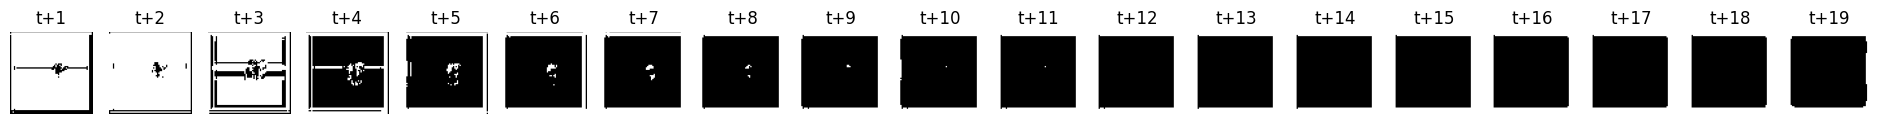

In [34]:
i=0
delta=8
L=len(y_val_pred[-1])

plt.figure(figsize=(24, 6))
for delta in range(L):
    plt.subplot(1, L, delta+1)
    plt.imshow(y_val_pred[-1][i+delta] > np.mean(y_val_pred[-1][i+delta]), cmap='gray')
    plt.title(f't+{delta+1}')
    plt.axis('off')

plt.show()